In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Flickr8k_text.zip'  # Replace with your actual zip file name
extract_path = '/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Image Caption Generator using CNN and LSTM/Flickr8k_text'     # Replace with the desired extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
zip_file_path = '/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Flickr8k_Dataset.zip'  # Replace with your actual zip file name
extract_path = '/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Image Caption Generator using CNN and LSTM/Flickr8k_Dataset'     # Replace with the desired extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

**Image Caption Generator Model:**

We merge CNN and RNN architectures. It is also called a CNN-RNN model.

* CNN is used for extracting features from the image. We will use the pre-trained model Xception.
* LSTM will use the information from CNN to help generate a description of the image.

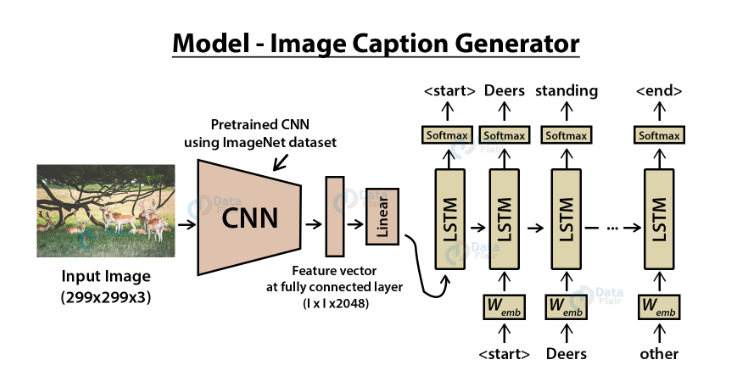

**Dataset Description:**
* **Flicker8k_Dataset** – Dataset folder which contains 8091 images
* **Flickr_8k_text** – Dataset folder which contains text files and captions of images.

**Project File Structure:**
* **Models** – It will contain our trained models.
*Descriptions.txt – This text file contains all image names and their captions after preprocessing.
* **Features.p** – Pickle object that contains an image and their feature vector extracted from the Xception pre-trained CNN model.
* **Tokenizer.p** – Contains tokens mapped with an index value.
* **Model.png** – Visual representation of dimensions of our project.
* **Testing_caption_generator.py** – Python file for generating a caption of any image.
* **Image Caption Generator using CNN and LSTM.ipynb** – Jupyter notebook in which we train and build our image caption generator.

**Import all required libraries:**

In [ ]:
import string
import numpy as np
import os
from PIL import Image
from pickle import dump, load

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-2-d2294d52f24f>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

Each image has 5 captions and we can see that #(0 to 4)number is assigned for each caption.

We will define 5 functions:

* **load_doc( filename )** – For loading the document file and reading the contents inside the file into a string.
* **all_img_captions( filename )** – This function will create a descriptions dictionary that maps images with a list of 5 captions.
* **cleaning_text( descriptions)** –  This function takes all descriptions and performs data cleaning.
* **text_vocabulary( descriptions )** – This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions.
* **save_descriptions( descriptions, filename )** – This function will create a list of all the descriptions that have been preprocessed and store them into a file.

In [ ]:
# 1. Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# 2. Get all imgages with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')

    # Dictionary of descriptions
    descriptions ={}

    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)

    return descriptions

# 3. Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]

            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]

            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]

            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]

            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption

    return captions

# 4. Create Vocabulary
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# 5. Save all cleaned descriptions in one file
# Each line in the file contains an image identifier and its corresponding cleaned caption.
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)

    file = open(filename,"w")
    file.write(data)
    file.close()


# Set these path according to project folder in you system
dataset_text = "/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Image Caption Generator using CNN and LSTM/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Image Caption Generator using CNN and LSTM/Flickr8k_Dataset/Flicker8k_Dataset"

# Prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

# Loading the file that contains all data
# Mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

# Cleaning the Descriptions
clean_descriptions = cleaning_text(descriptions)

# Building vocabulary from cleaned descriptions
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

# Saving each cleaned description to file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


**Extracting the feature vector from all images:**

* This technique is also called **Transfer learning**, we don’t have to do everything on our own, we use a pre-trained neural network model (Xception) to extract features from images in a specified directory
* One thing to notice is that the Xception model takes 299*299*3 image size as input. We will remove the last classification layer and get the 2048 feature vector.

In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}

        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)

            # Image normalization
            image = image/127.5
            image = image - 1.0

            # Use the pre-trained Xception model to extract features from the normalized image
            feature = model.predict(image)
            features[img] = feature  # stores the image filename as 'key' and extracted feature vector as 'value'

        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

83683744/83683744 [==============================] - 5s 0us/step


<ipython-input-4-b2ce20a08de3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 53ms/step


In [ ]:
features = load(open("features.p","rb"))

**Loading dataset for Training the model:** In our Flickr_8k_test folder, we have Flickr_8k.trainImages.txt file that contains a list of 6000 image names that we will use for training.

* **load_photos( filename )** – This will load the text file in a string and will return the list of image names.
* **load_clean_descriptions( filename, photos )** – This function will create a dictionary that contains captions for each photo from the list of photos. We also append the <start> and <end> identifier for each caption. We need this so that our LSTM model can identify the starting and ending of the caption.
* **load_features(photos)** – This function will give us the dictionary for image names and their feature vector which we have previously extracted from the Xception model.

In [ ]:
# Load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}

    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))

    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

**Tokenizing the vocabulary:** map each word of the vocabulary with a unique index value. Keras library provides us with the tokenizer function that we will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#c Ceating tokenizer class
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    # The fit_on_texts method is used to update the internal vocabulary based on the provided list of descriptions (desc_list)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# Give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
# Calculate Maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

**Create Data generator:** We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**For example:** The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

In [ ]:
# Create input-output sequence pairs from the image description.
# Data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

**Defining the CNN-RNN model:**

* **Feature Extractor** – The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.
* **Sequence Processor** – An embedding layer will handle the textual input, followed by the LSTM layer.
* **Decoder** – By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

**Training the model:**

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32, 256)              1939712   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]'] 

<ipython-input-11-36ad0bd263a6>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 566s 93ms/step - loss: 4.5100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6000/6000 [==============================] - 538s 90ms/step - loss: 2.7904


**Testing the model:** The model has been trained, now, we will make a separate file testing_caption_generator.py which will load the model and generate predictions.

In [ ]:
%%writefile testing_caption_generator.py

import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from pickle import load
import matplotlib.pyplot as plt

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension are correct")
    image = image.resize((299, 299))
    image = np.array(image)
    # For images that have 4 channels, we convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Main code
max_length = 32

# Load tokenizer
tokenizer = load(open("tokenizer.p", "rb"))

# Load pre-trained captioning model
model = load_model('models/model_9.h5')

# Load pre-trained Xception model
xception_model = Xception(include_top=False, pooling="avg")

# Specify the image path
img_path = "/content/drive/MyDrive/7.30 PM DATA SCIENCE AND AI/Image Caption Generator using CNN and LSTM/Flickr8k_Dataset/Flicker8k_Dataset/143552829_72b6ba49d4.jpg"  # Replace with the actual path to your image

# Extract features from the image
photo = extract_features(img_path, xception_model)

# Generate and print the caption
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)

# Display the image
img = Image.open(img_path)
plt.imshow(img)
plt.show()

Overwriting testing_caption_generator.py


1/1 [==============================] - 1s 1s/step



start man in red shirt and jeans on bike end


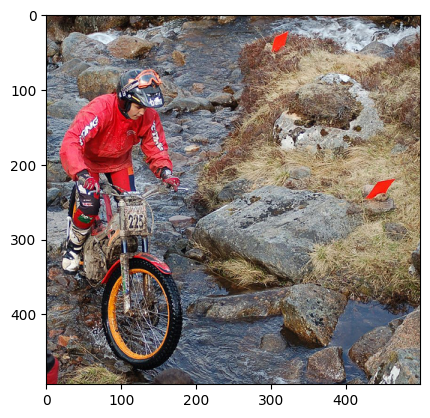

<Figure size 640x480 with 0 Axes>

In [ ]:
%run testing_caption_generator.py